<a href="https://colab.research.google.com/github/dhynasah/Drug-Discovery-project/blob/main/Part_2_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exploratory analysis for machine learing model**
Descriptor Calculation and Exploratory analysis will be preformed

In [ ]:
#install Codna and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
df = pd.read_csv('bioactivity_estrogen_preprocessed_data.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_classification
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,2.5,active
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,7.5,active
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,3.1,active
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,3.9,active
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,7.4,active


**Calculate Lipinski Descriptors**

The lipinski's rules include: 


*   Molecular weight <500 Dalton
*   Octonal- water partition coefficent (LogP)<5
*   Hydrogen bond donors <5
*   Hydrogen bond acceptors <10





In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df.shape

(3543, 4)

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

In [ ]:
#combine the 2 datasets
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_classification,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,2.5,active,439.621,6.04150,1.0,5.0
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,7.5,active,467.675,6.82170,1.0,5.0
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,3.1,active,463.599,5.92960,2.0,6.0
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,3.9,active,467.675,6.82170,1.0,5.0
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,7.4,active,461.627,6.09400,1.0,5.0
...,...,...,...,...,...,...,...,...
3538,CHEMBL4645341,CCOC(=O)C1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2...,220.0,active,440.496,2.36090,2.0,8.0
3539,CHEMBL4646745,N#CC1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2)cc1,13970.0,inactive,393.443,2.32138,2.0,7.0
3540,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,70.0,active,371.524,5.99610,0.0,2.0
3541,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,60.9,active,371.524,5.99610,0.0,2.0


**Convert IC50 to pIC50**

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially **-log10(IC50)**

this function will:


*   Take the IC50 values from the standard_value column and convert it from nM to M by multiplying the value by 10^-9
*   Take the Molar value and apply -log10
*   delete standard value colum and create a new pIC50 column







In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb
def pIC50(input):
  pIC50 = []
  
  for i in input['standard_value_norm']:
    molar = i*(10**-9) #Converts nM to M
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop('standard_value_norm',1)

  return x  


Values greater than 100,000,000 will be fixed at 100,000,000 otherwise negative logarithmic value will become negative

In [ ]:
# review summary statistics
df_combined.standard_value.describe()

count    3.543000e+03
mean     2.422645e+04
std      1.611709e+05
min      2.000000e-03
25%      1.100000e+01
50%      2.300000e+02
75%      6.440000e+03
max      5.000000e+06
Name: standard_value, dtype: float64

In [ ]:
-np.log10((10**-9) *100000000 )

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
def norm_value(input):
  norm = []
  for i in input['standard_value']:
    if i > 100000000:
      i =  100000000
    norm.append(i)
  input['standard_value_norm'] = norm
  x = input.drop('standard_value',1)
  return x

In [ ]:
#apply the norm_value() function so that the values in the standard_value column are normalized
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_classification,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,active,439.621,6.04150,1.0,5.0,2.5
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,7.5
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,active,463.599,5.92960,2.0,6.0,3.1
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,3.9
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,active,461.627,6.09400,1.0,5.0,7.4
...,...,...,...,...,...,...,...,...
3538,CHEMBL4645341,CCOC(=O)C1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2...,active,440.496,2.36090,2.0,8.0,220.0
3539,CHEMBL4646745,N#CC1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2)cc1,inactive,393.443,2.32138,2.0,7.0,13970.0
3540,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,70.0
3541,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,60.9


In [ ]:
# now the maximum values in 100,000,000
df_norm.standard_value_norm.describe()

count    3.543000e+03
mean     2.422645e+04
std      1.611709e+05
min      2.000000e-03
25%      1.100000e+01
50%      2.300000e+02
75%      6.440000e+03
max      5.000000e+06
Name: standard_value_norm, dtype: float64

In [ ]:
#apply pIC50 function to dataset
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_classification,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,active,439.621,6.04150,1.0,5.0,8.602060
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,8.124939
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,active,463.599,5.92960,2.0,6.0,8.508638
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,8.408935
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,active,461.627,6.09400,1.0,5.0,8.130768
...,...,...,...,...,...,...,...,...
3538,CHEMBL4645341,CCOC(=O)C1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2...,active,440.496,2.36090,2.0,8.0,6.657577
3539,CHEMBL4646745,N#CC1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2)cc1,inactive,393.443,2.32138,2.0,7.0,4.854804
3540,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,7.154902
3541,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,7.215383


In [ ]:
#Save final dataframe to csv file. This will be used in part 3 and 4 for building machine 
#learning model
#save bioactivity data to CSV file 
df_final.to_csv('bioactivity_estrogen_pIC50_data.csv', index= False)


#copy files to google drive 
from google.colab import drive
drive.mount('/content/gdrive/', force_remount= True)

! cp bioactivity_estrogen_pIC50_data.csv '/content/gdrive/My Drive/Colab Notebooks/data'

Mounted at /content/gdrive/


In [ ]:
! ls -l '/content/gdrive/My Drive/Colab Notebooks/data'

-rw------- 1 root root 478558 Jan 30 17:02 '/content/gdrive/My Drive/Colab Notebooks/data'


In [ ]:
! ls

bioactivity_estrogen_pIC50_data.csv	    plot_bioactivity_class.pdf
bioactivity_estrogen_preprocessed_data.csv  plot_iC50.pdf
drive					    plot_LogP.pdf
gdrive					    plot_MW.pdf
mannwhitneyu_LogP.csv			    plot_MW_vs_LogP.pdf
mannwhitneyu_MW.csv			    plot_NumHAcceptors.pdf
mannwhitneyu_NumHAcceptors.csv		    plot_NumHDonors.pdf
mannwhitneyu_NumHDonors.csv		    results.zip
mannwhitneyu_pIC50.csv			    sample_data
Miniconda3-py37_4.8.2-Linux-x86_64.sh


In [ ]:
df_final.pIC50.describe()

count    3543.000000
mean        6.635093
std         1.643990
min         2.301030
25%         5.191115
50%         6.638272
75%         7.958607
max        11.698970
Name: pIC50, dtype: float64

In [ ]:
#removing the intermediate class from our dataset to allow simple comparison 
#of active and inactive molecules
df_2class = df_final[df_final.bioactivity_classification !='intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_classification,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,active,439.621,6.04150,1.0,5.0,8.602060
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,8.124939
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,active,463.599,5.92960,2.0,6.0,8.508638
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,active,467.675,6.82170,1.0,5.0,8.408935
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,active,461.627,6.09400,1.0,5.0,8.130768
...,...,...,...,...,...,...,...,...
3538,CHEMBL4645341,CCOC(=O)C1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2...,active,440.496,2.36090,2.0,8.0,6.657577
3539,CHEMBL4646745,N#CC1=C(N)Oc2cc(O)ccc2C1c1ccc(OCCN2CCOCC2)cc1,inactive,393.443,2.32138,2.0,7.0,4.854804
3540,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,7.154902
3541,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,active,371.524,5.99610,0.0,2.0,7.215383


**Exploratory Data analysis (chemical space analysis) via Lipinski Descriptors**

In [ ]:
#import data visualization libraries
import seaborn as sns
sns.set(style= 'ticks')
import matplotlib.pyplot as plt

**Frequency plot of the 2 bioactivity categories**

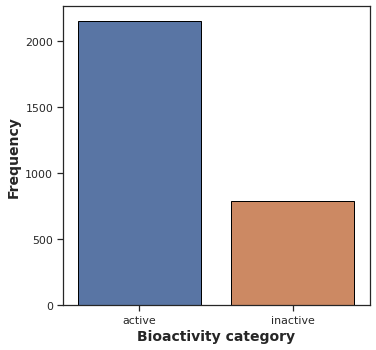

In [ ]:
plt.figure(figsize=(5.5,5.5))
sns.countplot(x='bioactivity_classification', data=df_2class, edgecolor= 'black')

plt.xlabel('Bioactivity category', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize= 14, fontweight='bold')
plt.savefig('plot_bioactivity_class.pdf')

**Scatter plot of Molecular weight vs LopP**
The 2 bioactivity categories occupy the sames space in the graph. Since they are overlapping that indicates they are spanning the same chemical spaces

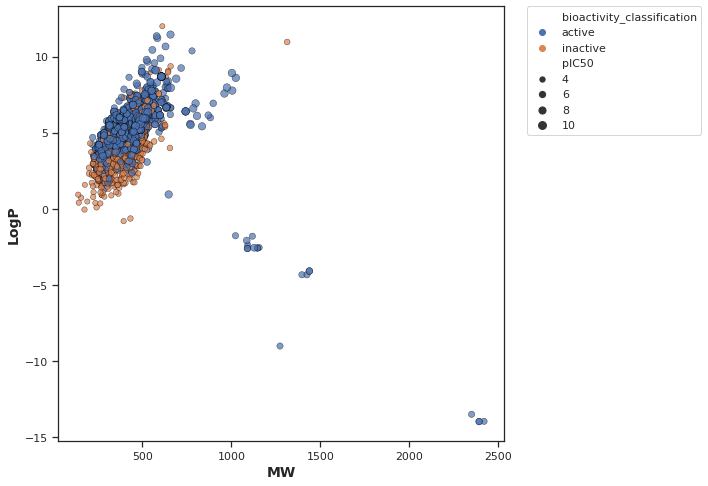

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='MW', y = 'LogP', data = df_2class, hue='bioactivity_classification', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**Box plots**
pIC50 value

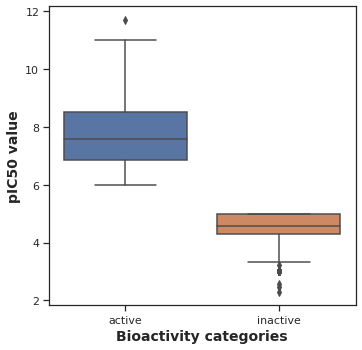

In [ ]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_classification',y='pIC50', data= df_2class)
plt.xlabel('Bioactivity categories', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value',fontsize=14, fontweight= 'bold')
plt.savefig('plot_iC50.pdf')

**Statistical analysis: Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_classification']
  df = df_2class[selection]
  active = df[df.bioactivity_classification == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_classification']
  df = df_2class[selection]
  inactive = df[df.bioactivity_classification == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


**Molecular Weight: MW**

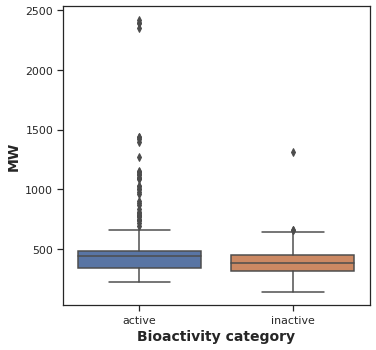

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_classification', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity category', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,648409.0,2.647802e-23,0.05,Different distribution (reject H0)


**LogP**

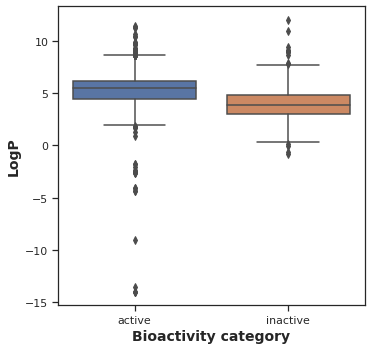

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_classification', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity category', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
#Statistical analysis | Mann-Whitney U Test
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,395990.0,8.267930e-110,0.05,Different distribution (reject H0)


**NumHDonors**

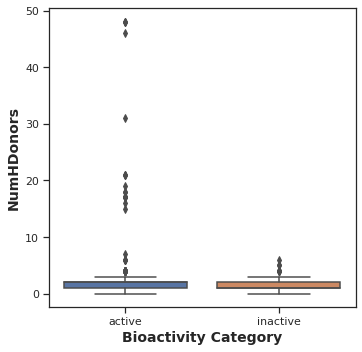

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_classification', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity Category', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,566173.0,3.244491e-52,0.05,Different distribution (reject H0)


**NumHAcceptors**

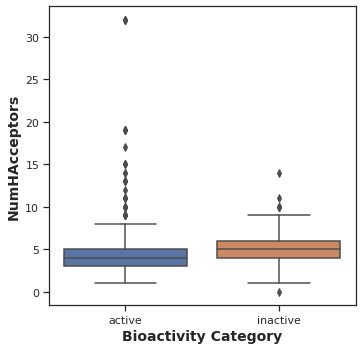

In [ ]:
#NumHAcceptors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_classification', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity Category', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,626907.5,7.500244e-29,0.05,Different distribution (reject H0)


# **Interpretation of Statisitical Results**

**pIC50 values**
Taking a look at pIC50 values, the inactives and actives displayed statistically significant difference.
This is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

**Lipinski's Descriptors**
All 4 Lipinski's descriptors (MW,LOGP NUMHDonors, and NUMHAcceptors) show statistically significant difference between actives and inactives.


**Zip  all relavent Files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf